### fMRI learn project - fmri_prep and related steps

#### Author: Boqian Shi

In [5]:
# Result csv reading
import sys
sys.path.append('/home/bqshi/workspace/fmri_topolearn')
sys.path.append('/home/bqshi/workspace/fmri_topolearn/src')
from src import subjects
# print(subjects.results)


In [5]:
print(subjects.to_convert_to_BIDs)
print(len(subjects.to_convert_to_BIDs))

['013S4791', '019S4549', '041S5026', '002S4746', '129S4369', '018S4809', '031S2017', '129S4287', '006S0731', '006S4960', '002S4654', '130S4660', '136S4433', '010S4442', '136S4956', '019S4835', '018S2155', '019S4680', '018S5240', '031S4032', '053S5070', '018S2138', '013S4236', '031S4194', '012S4545', '129S0778', '130S2403', '019S4252', '130S4405', '013S4395', '053S2396', '100S4511', '012S4094', '100S4884', '031S4029', '012S4026', '130S4468', '031S2018', '130S4971', '136S0186', '053S4813', '006S4713', '130S2391', '013S4268', '100S4512', '130S5231', '136S4269', '031S4024', '130S2373', '006S4546', '130S4641', '031S4721', '010S4345', '006S4679', '013S4985', '019S4367', '130S4997', '130S4352', '018S2180', '130S4605', '018S4399', '129S4371', '031S4476', '100S5246', '006S4192', '013S4616', '100S4556', '031S4149', '100S4469', '006S4449', '031S2022', '019S4548', '018S4597', '130S4730', '031S4021', '136S4848', '130S4542', '006S4363', '130S4925', '002S4473', '019S4477', '019S4293', '129S4422', '00

In [1]:
import csv

# The path to your CSV file
csv_file_path = '/home/bqshi/workspace/fmri_topolearn/data/01_bids/participants.tsv'

# Initialize an empty list to store the processed results
processed_results = []

# Function to transform the participant identifier
def transform_identifier(identifier):
    # Split the identifier and insert underscores
    return identifier.replace('sub-', '')

# Read the CSV file
with open(csv_file_path, mode='r') as csv_file:
    # Create a CSV reader
    csv_reader = csv.reader(csv_file)
    
    # Skip the header row if there's any, uncomment the next line
    # next(csv_reader, None)
    
    # Process each row in the CSV file
    for row in csv_reader:
        # Assuming the participant identifier is in the first column
        participant_identifier = row[0]
        
        # Append the transformed identifier to the list
        processed_results.append(transform_identifier(participant_identifier))

# Print the list of transformed identifiers
print(processed_results)
phase2 = ['002S0413', '002S1261', '002S1280', '002S2073', '002S4213', '002S4219', '002S4225', '002S4229', '002S4251', '002S4262', '002S4264', '002S4270',  '002S4473']
# AD IDs:
'''
136S4993
131S5138
130S5231
130S5059
130S5006
130S4997
130S4990
130S4984
130S4982
130S4971
130S4730
130S4660
130S4641
130S4589
100S5106
053S5208
053S5070
031S4024
019S5019
019S5012
019S4549
019S4477
019S4252
018S5240
018S5074
018S4733
018S4696
013S5071
010S5163
006S4867
006S4546
006S4192
006S4153
002S5018
'''

['002S0295', '002S0413', '002S0685', '002S1261', '002S1280', '002S2010', '002S2043', '002S2073', '002S4171', '002S4213', '002S4219', '002S4225', '002S4229', '002S4237', '002S4251', '002S4262', '002S4264', '002S4270', '002S4447', '002S4473', '002S0295']


In [9]:
from config import *
import glob, os
import pandas as pd

def dicom_to_bids(to_convert_to_BIDs):
    
    global dicom_dir
    participants_file = open("%s/data/01_bids/participants.tsv"%(rootdir),"a+")
    for sub in to_convert_to_BIDs:
        if os.path.isdir('%s/data/01_bids/sub-%s/ses-1/anat'%(rootdir,sub)) and\
    len(os.listdir('%s/data/01_bids/sub-%s/ses-1/anat'%(rootdir,sub))) != 0:
            print('sub-%s: already covnverted'%sub)
            continue
        dirc = dicom_dir + '/sub-'+sub
        if not os.path.isdir(dirc):
            print('sub-%s: could not find DICOM files'%sub)
            continue
        SubFiles = glob.glob(dirc + '/*')
        if len(SubFiles) < 6:
            os.system('find %s -maxdepth 1 -type f -exec rm -f {} \;'%dirc)
            os.system('dcm2niix -f %%f_%%p_%%t_%%S -p y -z y -ba n %s'%dirc)
        elif len(SubFiles) > 6:
            print(SubFiles)
            print('sub-%s: dcm2niix generated more than 4 files. conversion failed'%sub)
            continue
        print('sub-%s: converted'%sub)
        participants_file.write("sub-%s\r\n" %(sub))
    participants_file.close()
    
    p = pd.read_csv("%s/data/01_bids/participants.tsv"%(rootdir), sep='\t')
    p=p.drop_duplicates()
    p.to_csv("%s/data/01_bids/participants.tsv"%(rootdir),index=False, sep='\t')

In [7]:
import os
import glob
from config import *

def organize_all(to_convert_to_BIDs):
    for sub in to_convert_to_BIDs:
        # print(sub)
        organize_bids_files(sub)

def organize_bids_files(sub):
    """
    Organize and move nii.gz and JSON files to the BIDS folder, matching MPRAGE and fMRI scans by date.

    Parameters:
    - sub: Subject identifier.
    - rootdir: Root directory where BIDS data is stored.
    """
    dicom_dir = f"{rootdir}/data/00_dicom/sub-{sub}"
    bids_dir = f"{rootdir}/data/01_bids/sub-{sub}"
    
    # Load all files for the subject
    all_files = glob.glob(f"{dicom_dir}/*")
    
    # Filter out MPRAGE and fMRI files, ignoring MPRAGE_SENSE2
    mprage_files = [f for f in all_files if "MPRAGE" in f and "SENSE2" not in f]
    fmri_files = [f for f in all_files if "Resting_State_fMRI" in f]
    
    # Organize files by date (first 8 digits of the timestamp)
    sessions = {}
    for file in mprage_files + fmri_files:
        date = file.split('_')[-2][:8]  # Extract date from filename
        if date not in sessions:
            sessions[date] = {'mprage': [], 'fmri': []}
        if "MPRAGE" in file:
            sessions[date]['mprage'].append(file)
        else:
            sessions[date]['fmri'].append(file)
    
    # Copy files to the BIDS structure, naming sessions sequentially
    session_count = 1  # Start session count
    for session_date, files in sessions.items():
        # Proceed only if there's at least one matched pair of MPRAGE and fMRI scans
        if len(files['mprage']) > 0 and len(files['fmri']) > 0:
            session_id = f"ses-{session_count}"
            os.makedirs(f"{bids_dir}/{session_id}/anat", exist_ok=True)
            os.makedirs(f"{bids_dir}/{session_id}/func", exist_ok=True)
            
            # Assuming one-to-one matching, proceed with copying both JSON and NII.GZ for each
            mprage_file = files['mprage'][0]  # Assuming the first file is representative
            fmri_file = files['fmri'][0]  # Assuming the first file is representative
            
            # MPRAGE - Copy both .nii.gz and .json files
            for ext in ['.nii.gz', '.json']:
                file_to_copy = mprage_file.replace('.nii.gz', ext).replace('.json', ext)
                basename = os.path.basename(file_to_copy)
                target_name = f"sub-{sub}_{session_id}_T1w{ext}"
                os.system(f"cp '{file_to_copy}' '{bids_dir}/{session_id}/anat/{target_name}'")
            
            # fMRI - Copy both .nii.gz and .json files
            for ext in ['.nii.gz', '.json']:
                file_to_copy = fmri_file.replace('.nii.gz', ext).replace('.json', ext)
                basename = os.path.basename(file_to_copy)
                target_name = f"sub-{sub}_{session_id}_task-rest_bold{ext}"
                os.system(f"cp '{file_to_copy}' '{bids_dir}/{session_id}/func/{target_name}'")
            
            session_count += 1  # Increment session count for next matched session

In [ ]:
phase1 = processed_results
dicom_to_bids(subjects.to_convert_to_BIDs)
organize_all(subjects.to_convert_to_BIDs)

In [48]:
from src import subjects
from config import * 
path = rootdir + "/src/scripts/fMRIPrep_preprocessing.sh"

# print(subjects.to_preprocess)
# print(phase1)
s = ""
for sub in phase1:
    if sub != '002S0295':
        s += sub + " "
print(s)

002S0413 002S0685 002S1261 002S1280 002S2010 002S2043 002S2073 002S4171 002S4213 002S4219 002S4225 002S4229 002S4237 002S4251 002S4262 002S4264 002S4270 002S4447 002S4473 


In [31]:
print(path)

/home/bqshi/workspace/fmri_topolearn/src/scripts/fMRIPrep_preprocessing.sh


In terminal, run:
```bash 
bash /home/bqshi/workspace/fmri_topolearn/src/scripts/fMRIPrep_preprocessing.sh
 ```

OR run the following script to process multiple cases at the same time:

```bash 
bash /home/bqshi/workspace/fmri_topolearn/src/scripts/multiple_preprocessing.sh
 ```

In [6]:
import sys
from src import subjects
print('Denoising waiting list:\n',subjects.to_denoise)
if subjects.to_denoise == []:
    sys.exit("There is no subject to be denoised!")
sub = subjects.to_denoise[0]
ses = 1
print('Currently processing: subject %s'%sub)


Denoising waiting list:
 ['002S2043', '002S4237', '130S4997', '136S4993', '031S4024', '002S4213', '131S5138', '002S1261', '002S2010', '002S4447', '130S5231', '002S1280', '002S2073', '002S0413']
Currently processing: subject 002S2043


In [7]:
#%matplotlib notebook
from config import *
from src import subjects
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nilearn.plotting
import nilearn.datasets
import nilearn.signal
import nibabel
import sklearn.preprocessing
import pkg_resources


def denoise(sub):
    """
    """
    ses = 1
    #DATA_PATH = pkg_resources.resource_filename('brainnetworks', 'data/')
    from src import subjects
    subdir=subjects.preprocesseddir + '/sub-%s'%sub
    assert os.path.exists(subdir)

    sesdir=os.path.join(subdir,'ses-%d/func'%ses)

    # get freesurfer data if we don't already have it
    fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage5')
    print('processing sub-%s'%sub)
    # number of timepoints
    ld1 = os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s.func.gii'%(sub,ses,'L'))
    ld2 = os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s_bold.func.gii'%(sub,ses,'L'))

    try: 
        ntp=len(nibabel.load(ld1).darrays)
    except FileNotFoundError:
        ntp=len(nibabel.load(ld2).darrays)

    # load the preprocessed fMRI data

    hemispheres=['L','R']
    bold_origfile={}
    nverts=10242  # number of vertices in fsaverage5 per hemisphere
    bolddata_orig=np.zeros((ntp,nverts*2))
    for i,h in enumerate(hemispheres):

        try:
            bold_origfile[h]=os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s.func.gii'%(sub,ses,h))
            d=nibabel.load(bold_origfile[h]).darrays
        except FileNotFoundError:
            bold_origfile[h]=os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s_bold.func.gii'%(sub,ses,h))
            d=nibabel.load(bold_origfile[h]).darrays
        for tp in range(len(d)):
            bolddata_orig[tp,(i*nverts):((i+1)*nverts)]=d[tp].data

    print('data shape:',bolddata_orig.shape)
   

    # load the confound data

    confounds=pd.read_csv(os.path.join(sesdir,
                        'sub-%s_ses-%d_task-rest_desc-confounds_timeseries.tsv'%(sub,ses)),
                         sep='\t',na_values='n/a')
    confounds=confounds.replace(np.nan,0)

    # add temporal derivatives of motion estimates
    # motionvars=['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']
    # estimated head-motion parameters:
    motionvars=['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']

    for v in motionvars:
        confounds['%s_derivative1'%v]=0
        confounds['%s_derivative1'%v].iloc[1:]=confounds[v].iloc[1:].values - confounds[v].iloc[:-1].values
    
    #First we'll load in our data and check the shape
    bolddata = bolddata_orig
    try:
        a = confounds['non_steady_state_outlier00'].index[confounds['non_steady_state_outlier00'] == 1].tolist()[0]
        bolddata = bolddata_orig[a+1:,:]
        confounds = confounds.loc[a+1:]
    except:    
        pass
    ntp = confounds.shape[0]
    
    #Creatin Confounds tables:
    confounds9p = ['csf', 'white_matter', 'global_signal','trans_x', 'trans_y', 'trans_z',
                   'rot_x', 'rot_y', 'rot_z',]
    confounds36p = confounds9p + ['csf_derivative1', 'csf_derivative1_power2', 'csf_power2',
                                    'white_matter_derivative1', 'white_matter_derivative1_power2', 'white_matter_power2',
                                    'global_signal_derivative1', 'global_signal_derivative1_power2', 'global_signal_power2',
                                    'trans_x_derivative1', 'trans_x_derivative1_power2', 'trans_x_power2',
                                    'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2',
                                    'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2',
                                    'rot_x_derivative1', 'rot_x_derivative1_power2', 'rot_x_power2',
                                    'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
                                    'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2',
                                  ]
    confounds9p = confounds[confounds9p]
    confounds36p = confounds[confounds36p]
    
    #First create a matrix of zeroes that matches our signals matrix
    bolddata9p = np.zeros_like(bolddata)
    bolddata36p = np.zeros_like(bolddata)

    #Apply only to brain voxels
    bolddata9p = nilearn.signal.clean(bolddata, confounds=confounds9p.values)
    bolddata36p = nilearn.signal.clean(bolddata, confounds=confounds36p.values)
    
    atlasdir=rootdir + '/references/HCP-MMP1'
    atlas={'L':'lh.HCP-MMP1.fsaverage5.gii','R':'rh.HCP-MMP1.fsaverage5.gii'}
    atlasdata={}
    atlaslabels={}
    for a in atlas:
       atlaslabeltable=nibabel.load(os.path.join(atlasdir,atlas[a])).labeltable.labels
       atlaslabels[a]=[i.label for i in atlaslabeltable[1:]]
       atlasdata[a]=nibabel.load(os.path.join(atlasdir,atlas[a])).darrays[0].data 
    allatlaslabels=atlaslabels['L']+atlaslabels['R']
    allatlasdata=np.hstack((atlasdata['L'],atlasdata['R']+180))  
    
    roidata    = np.zeros((ntp,361))
    roidata9p  = np.zeros((ntp,361))
    roidata36p = np.zeros((ntp,361))

    for region in range(361):
        if region == 0:
            continue
        regionverts = allatlasdata == region
        for tp in range(ntp):
            tmp = bolddata[tp,:]
            roidata[tp,region] = np.mean(tmp[regionverts])
            tmp = bolddata9p[tp,:]
            roidata9p[tp,region] = np.mean(tmp[regionverts])
            tmp = bolddata36p[tp,:]
            roidata36p[tp,region] = np.mean(tmp[regionverts])
    fd_thresh=0.5
    tps_exceeding_fd_thresh=np.where(confounds.framewise_displacement.values>fd_thresh)
    tswindow=10
    tsmask=np.ones(confounds.shape[0])
    for tp in tps_exceeding_fd_thresh[0]:
        tsmask[(tp-1):(tp+tswindow)]=0

    # print('%d good timepoints remaining after scrubbing (%d removed)'%(np.sum(tsmask),
    #                                                                   ntp - np.sum(tsmask)))
    roidata36p_scrubbed=roidata36p[np.where(tsmask)[0],:]
    os.system('mkdir -p %s/data/03_time_series/ds-9p %s/data/03_time_series/ds-36p \
    %s/data/03_time_series/ds-36pscrubbed %s/data/03_time_series/ds-raw'
              %(rootdir,rootdir,rootdir,rootdir))

    np.save("%s/data/03_time_series/ds-9p/sub-%s_ds-9p"
            %(rootdir, sub), roidata9p)
    np.save("%s/data/03_time_series/ds-36p/sub-%s_ds-36p"
            %(rootdir, sub), roidata36p)
    np.save("%s/data/03_time_series/ds-36pscrubbed/sub-%s_ds-36pscrubbed"
            %(rootdir, sub), roidata36p_scrubbed)
    np.save("%s/data/03_time_series/ds-raw/sub-%s_ds-raw"
            %(rootdir, sub), roidata)
    
def denoise_all(subs):
    """
    """
   
    for sub in subs:
        denoise(sub)

In [ ]:
# Finished by March 8th, 2024
finished = ["002S0295", "002S0413", "002S0685", "002S1261",
    "002S1280","002S2010","002S2043","002S2073","002S4171","002S4213","002S4219",
    "002S4237","002S4447","031S4024","130S4997","130S5231","131S5138","136S4993",]
denoise_all(finished)

In [10]:
sub

'002S2043'

In [11]:
%matplotlib inline
#%matplotlib notebook
from config import *
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nilearn.plotting
import nilearn.datasets
import nilearn.signal
import nibabel
import sklearn.preprocessing
import pkg_resources

#DATA_PATH = pkg_resources.resource_filename('brainnetworks', 'data/')                                        

subdir=subjects.preprocesseddir + '/sub-%s'%sub
assert os.path.exists(subdir)

sesdir=os.path.join(subdir,'ses-%d/func'%ses)

# get freesurfer data if we don't already have it
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage5')

In [12]:
# number of timepoints
ld1 = os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s.func.gii'%(sub,ses,'L'))
ld2 = os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s_bold.func.gii'%(sub,ses,'L'))

try: 
    ntp=len(nibabel.load(ld1).darrays)
except FileNotFoundError:
    ntp=len(nibabel.load(ld2).darrays)

# load the preprocessed fMRI data

hemispheres=['L','R']
bold_origfile={}
nverts=10242  # number of vertices in fsaverage5 per hemisphere
bolddata_orig=np.zeros((ntp,nverts*2))
for i,h in enumerate(hemispheres):
    
    try:
        bold_origfile[h]=os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s.func.gii'%(sub,ses,h))
        d=nibabel.load(bold_origfile[h]).darrays
    except FileNotFoundError:
        bold_origfile[h]=os.path.join(sesdir,'sub-%s_ses-%d_task-rest_space-fsaverage5_hemi-%s_bold.func.gii'%(sub,ses,h))
        d=nibabel.load(bold_origfile[h]).darrays
    for tp in range(len(d)):
        bolddata_orig[tp,(i*nverts):((i+1)*nverts)]=d[tp].data

print('data shape:',bolddata_orig.shape)

data shape: (140, 20484)


In [28]:
bolddata_orig.shape

(140, 20484)

/tmp/ipykernel_1581631/1662826263.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confounds['%s_derivative1'%v].iloc[1:]=confounds[v].iloc[1:].values - confounds[v].iloc[:-1].values
/tmp/ipykernel_1581631/1662826263.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.00000000e+00 -1.71351000e-02  1.68000000e-05  5.96110000e-03
 -5.97040000e-03  2.91000000e-05  1.32825300e-02  6.17348000e-03
  5.07141000e-03 -1.48097300e-02 -1.69954900e-02  1.31471000e-02
  1.42900000e-04 -5.92740000e-03 -1.19699000e-02  1.19806000e-02
  2.31510300e-02 -6.98664300e-02  6.19097700e-02 -3.34569700e-02
 -1.90213000e-02  5.74435500e-02 -5.95981000e-03  5.76881000e-03
 -2.81191500e-02 -1.42106000e-02  1.48215000e-02  2.85854800e-02
 -4.64791800

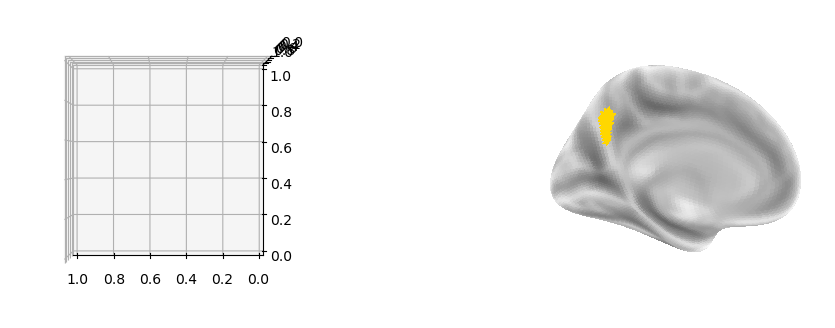

In [34]:
# load the confound data

confounds=pd.read_csv(os.path.join(sesdir,
                        'sub-%s_ses-%d_task-rest_desc-confounds_timeseries.tsv'%(sub,ses)),
                         sep='\t',na_values='n/a')
confounds=confounds.replace(np.nan,0)

# add temporal derivatives of motion estimates
# motionvars=['X', 'Y', 'Z', 'RotX', 'RotY', 'RotZ']
# estimated head-motion parameters:
motionvars=['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']

for v in motionvars:
    confounds['%s_derivative1'%v]=0
    confounds['%s_derivative1'%v].iloc[1:]=confounds[v].iloc[1:].values - confounds[v].iloc[:-1].values


# print('confound variables:',confounds.columns)

# plt.imshow(sklearn.preprocessing.scale(confounds).T,aspect='auto',
#           cmap='viridis',interpolation='nearest')
    
    #First we'll load in our data and check the shape
bolddata = bolddata_orig
try:
    a = confounds['non_steady_state_outlier00'].index[confounds['non_steady_state_outlier00'] == 1].tolist()[0]
    bolddata = bolddata_orig[a+1:,:]
    confounds = confounds.loc[a+1:]
except:    
    pass
ntp = confounds.shape[0]

#Creatin Confounds tables:
confounds9p = ['csf', 'white_matter', 'global_signal','trans_x', 'trans_y', 'trans_z',
               'rot_x', 'rot_y', 'rot_z',]
confounds36p = confounds9p + ['csf_derivative1', 'csf_derivative1_power2', 'csf_power2',
                                'white_matter_derivative1', 'white_matter_derivative1_power2', 'white_matter_power2',
                                'global_signal_derivative1', 'global_signal_derivative1_power2', 'global_signal_power2',
                                'trans_x_derivative1', 'trans_x_derivative1_power2', 'trans_x_power2',
                                'trans_y_derivative1', 'trans_y_derivative1_power2', 'trans_y_power2',
                                'trans_z_derivative1', 'trans_z_derivative1_power2', 'trans_z_power2',
                                'rot_x_derivative1', 'rot_x_derivative1_power2', 'rot_x_power2',
                                'rot_y_derivative1', 'rot_y_derivative1_power2', 'rot_y_power2',
                                'rot_z_derivative1', 'rot_z_derivative1_power2', 'rot_z_power2',
                              ]
confounds9p = confounds[confounds9p]
confounds36p = confounds[confounds36p]

#First create a matrix of zeroes that matches our signals matrix
bolddata9p = np.zeros_like(bolddata)
bolddata36p = np.zeros_like(bolddata)

#Apply only to brain voxels
bolddata9p = nilearn.signal.clean(bolddata, confounds=confounds9p.values)
bolddata36p = nilearn.signal.clean(bolddata, confounds=confounds36p.values)

atlasdir=rootdir + '/references/HCP-MMP1'
atlas={'L':'lh.HCP-MMP1.fsaverage5.gii','R':'rh.HCP-MMP1.fsaverage5.gii'}
atlasdata={}
atlaslabels={}
for a in atlas:
   atlaslabeltable=nibabel.load(os.path.join(atlasdir,atlas[a])).labeltable.labels
   atlaslabels[a]=[i.label for i in atlaslabeltable[1:]]
   atlasdata[a]=nibabel.load(os.path.join(atlasdir,atlas[a])).darrays[0].data 
allatlaslabels=atlaslabels['L']+atlaslabels['R']
allatlasdata=np.hstack((atlasdata['L'],atlasdata['R']+180))  

roidata    = np.zeros((ntp,361))
roidata9p  = np.zeros((ntp,361))
roidata36p = np.zeros((ntp,361))

for region in range(361):
    if region == 0:
        continue
    regionverts = allatlasdata == region
    for tp in range(ntp):
      tmp = bolddata[tp,:]
      roidata[tp,region] = np.mean(tmp[regionverts])
      tmp = bolddata9p[tp,:]
      roidata9p[tp,region] = np.mean(tmp[regionverts])
      tmp = bolddata36p[tp,:]
      roidata36p[tp,region] = np.mean(tmp[regionverts])

fd_thresh=0.5
tps_exceeding_fd_thresh=np.where(confounds.framewise_displacement.values>fd_thresh)
tswindow=10
tsmask=np.ones(confounds.shape[0])
for tp in tps_exceeding_fd_thresh[0]:
    tsmask[(tp-1):(tp+tswindow)]=0

# print('%d good timepoints remaining after scrubbing (%d removed)'%(np.sum(tsmask),
#                                                                   ntp - np.sum(tsmask)))

roidata36p_scrubbed=roidata36p[np.where(tsmask)[0],:]

parcelnum=30
# print('using region %d: %s'%(parcelnum,atlaslabels['L'][parcelnum]))

f,ax=plt.subplots(1,2,subplot_kw={"projection": "3d"},figsize=(12,4))
ax[0].view_init(270,270)
ntp_to_plot=100
# ax[0].plot(range(ntp_to_plot),roidata36p[:ntp_to_plot,parcelnum],zs=0)
nilearn.plotting.plot_surf_roi(fsaverage['infl_left'], 
                                    (atlasdata['L']==parcelnum).astype('int'),thresh=0.5,
                                    hemi='left',bg_map=fsaverage['sulc_left'],
                                   view='medial',cmap='prism',axes=ax[1])
os.system('mkdir -p %s/data/03_time_series/ds-9p %s/data/03_time_series/ds-36p \
%s/data/03_time_series/ds-36pscrubbed %s/data/03_time_series/ds-raw'
          %(rootdir,rootdir,rootdir,rootdir))

np.save("%s/data/03_time_series/ds-9p/sub-%s_ds-9p"
        %(rootdir, sub), roidata9p)
np.save("%s/data/03_time_series/ds-36p/sub-%s_ds-36p"
        %(rootdir, sub), roidata36p)
np.save("%s/data/03_time_series/ds-36pscrubbed/sub-%s_ds-36pscrubbed"
        %(rootdir, sub), roidata36p_scrubbed)
np.save("%s/data/03_time_series/ds-raw/sub-%s_ds-raw"
        %(rootdir, sub), roidata)

In [13]:
from config import *
from src import subjects
import numpy as np
import matplotlib.pyplot as plt
from config import *
import os,sys
import pandas as pd
from pandas import DataFrame as df
import networkx as nx
import nilearn
from nilearn.connectome import ConnectivityMeasure
from sklearn import covariance, preprocessing

def all_pearsons(subs):
	"""Compute Pearson correlation for all subjects in list subs
	subs : list of subjects IDs
	"""
	print('Computing Pearson correlation')
	for sub in subs:
		get_pearson(sub)
		
def get_pearson(sub):
	"""Compute Pearson correlation
	sub : subjects ID
	"""
	from src import subjects
	print("processing sub-%s"%sub)
	for ds in denoising_strategies:
		ts = np.load("%s/ds-%s/sub-%s_ds-%s.npy"%(subjects.time_seriesdir, ds, sub, ds))
		correlation = np.corrcoef(ts[:,1:].T)
		# we end up with a few NAN values because of an empty ROI, for now just zero them out
		correlation[np.isnan(correlation)] = 0

		np.save("%s/data/04_correlations/corr-%s/ds-%s/sub-%s_ds-%s_corr-%s"
			%(rootdir,'pearson',ds,sub,ds,'pearson'),correlation)
		Gr=nx.from_numpy_array(correlation)
		nx.write_gexf(Gr,"%s/data/04_correlations/corr-%s/ds-%s/sub-%s_ds-%s_corr-%s.gexf"
			%(rootdir,'pearson',ds,sub,ds,'pearson'))

In [14]:


all_pearsons(finished)

Computing Pearson correlation
processing sub-002S0295


/home/bqshi/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bqshi/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


processing sub-002S0413
processing sub-002S0685
processing sub-002S1261
processing sub-002S1280
processing sub-002S2010
processing sub-002S2043
processing sub-002S2073
processing sub-002S4171
processing sub-002S4213
processing sub-002S4219
processing sub-002S4237
processing sub-002S4447
processing sub-031S4024
processing sub-130S4997
processing sub-130S5231
processing sub-131S5138
processing sub-136S4993


In [37]:
%matplotlib inline
#%matplotlib notebook
from src import subjects, connectivity
import sys
import os,sys
import pandas as pd
from pandas import DataFrame as df
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import nibabel
from nibabel.gifti.gifti import GiftiImage,GiftiDataArray
from nilearn.connectome import ConnectivityMeasure
import nilearn.plotting
import sklearn.preprocessing
import sklearn.linear_model
import networkx as nx

correlation_types = ['pearson']

In [38]:
temp

['002S4171', '002S0295', '002S0685']